In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [449]:
import pathlib
import glob
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision
from tensorflow.keras.models import load_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [382]:
train_img_path = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Capstone/data/American Sign Language Letters.v1-v1.voc/new_train_imgs")
train_annot_path = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Capstone/data/American Sign Language Letters.v1-v1.voc/new_train_annot")
test_img_path = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Capstone/data/American Sign Language Letters.v1-v1.voc/new_test_imgs")
test_annot_path = pathlib.Path("C:/Users/vmoha/MPCS/Applied Data Analysis/Capstone/data/American Sign Language Letters.v1-v1.voc/new_test_annot")

train_images = sorted(glob.glob(os.path.join(train_img_path, "*.jpg")))
train_annotations = sorted(glob.glob(os.path.join(train_annot_path, "*.xml")))
test_images = sorted(glob.glob(os.path.join(test_img_path, "*.jpg")))
test_annotations = sorted(glob.glob(os.path.join(test_annot_path, "*.xml")))

In [383]:
train_df = pd.read_pickle("./data/train_df.pkl")
test_df = pd.read_pickle("./data/test_df.pkl")

### Function to Isolate Hand

I created a quick function here to build the base logic for taking in a hand image path, looking at the train_df for its bounding box, and returning an adjusted image with only the pixels that are within the bounding box. 

In [5]:
def isolate_hand(img_name):
    df_entry = train_df[train_df['Image'] == img_name]
    idx = df_entry.index[0]
    img_path = train_images[idx]
    
    img = cv2.imread(img_path)
    xmin, xmax, ymin, ymax = df_entry['Bounding_Box'].values[0]
    
    b_img = img[ymin:ymax, xmin:xmax]
    
    return b_img

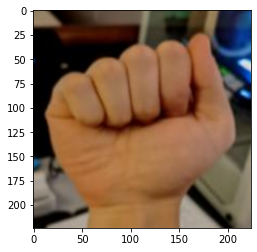

In [6]:
b_img = isolate_hand("A1_1.jpg")
b_img = cv2.resize(b_img, (224,224))

plt.imshow(cv2.cvtColor(b_img, cv2.COLOR_BGR2RGB))

### Preprocessing Data into Arrays

In [7]:
image_arrays = []

for idx, path in enumerate(train_images):
    df_entry = train_df.iloc[idx]
    img = cv2.imread(path)
    
    xmin, xmax, ymin, ymax = df_entry['Bounding_Box']
    b_img = img[ymin:ymax, xmin:xmax]
    b_img = cv2.resize(b_img, (224,224))
    
    image_arrays.append(b_img)
    

In [8]:
data = []
for array in image_arrays:
    prep_array = preprocess_input(array)
    data.append(prep_array)
data = np.array(data)

In [41]:
data.shape

(1512, 224, 224, 3)

In [422]:
train_labels = train_df['Letter']

In [423]:
lb = LabelEncoder()
train_labels = lb.fit_transform(train_labels)
train_labels = to_categorical(train_labels)
train_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [11]:
lb.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
      dtype=object)

In [194]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.1,
                           height_shift_range=0.1,
                            shear_range=0.1,horizontal_flip=True,validation_split=0.2)

In [337]:
aug = ImageDataGenerator(
    # rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.1,
)


### Modeling

In [338]:
IMG_SHAPE = (224, 224, 3)

In [339]:
mobilenet = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [340]:
handModel = mobilenet.output
handModel = AveragePooling2D(pool_size=(7, 7))(handModel)
handModel = Flatten(name="flatten")(handModel)
handModel = Dense(64, activation="relu")(handModel)
# handModel = Dense(32, activation="relu")(handModel)
handModel = Dropout(0.5)(handModel)
handModel = Dense(26, activation="softmax")(handModel)

In [341]:
model = Model(inputs=mobilenet.input, outputs=handModel)

for layer in mobilenet.layers:
    layer.trainable = False

In [342]:
# compile our model
opt = Adam(weight_decay=0.2)


model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy", Precision()])

# train the head of the network
history = model.fit(
   aug.flow(data, train_labels, 
           ), epochs=50,
)

Epoch 1/50
48/48 [==============================] - 28s 524ms/step - loss: 3.1030 - accuracy: 0.1210 - precision_20: 0.7500
Epoch 2/50
48/48 [==============================] - 26s 531ms/step - loss: 2.5714 - accuracy: 0.2374 - precision_20: 0.7949
Epoch 3/50
48/48 [==============================] - 25s 511ms/step - loss: 2.1170 - accuracy: 0.3591 - precision_20: 0.8119
Epoch 4/50
48/48 [==============================] - 25s 526ms/step - loss: 1.7847 - accuracy: 0.4544 - precision_20: 0.8530
Epoch 5/50
48/48 [==============================] - 26s 523ms/step - loss: 1.5425 - accuracy: 0.5437 - precision_20: 0.8722
Epoch 6/50
48/48 [==============================] - 25s 506ms/step - loss: 1.3607 - accuracy: 0.5813 - precision_20: 0.8808
Epoch 7/50
48/48 [==============================] - 25s 511ms/step - loss: 1.2681 - accuracy: 0.6151 - precision_20: 0.8648
Epoch 8/50
48/48 [==============================] - 25s 506ms/step - loss: 1.1389 - accuracy: 0.6481 - precision_20: 0.8953
Epoch 9/

In [343]:
model.save('model_1.h5')

Best:
- datagen: horizontal_flip: True, zoom_range: 0.1, 
- opt: adam(weight_decay = 0.2)
- Acc: 0.55 in 5 epochs

### Setting Up Prediction

In [391]:
test_image_arrays = []

for idx, path in enumerate(test_images):
    df_entry = test_df.iloc[idx]
    img = cv2.imread(path)
    
    xmin, xmax, ymin, ymax = df_entry['Bounding_Box']
    b_img = img[ymin:ymax, xmin:xmax]
    b_img = cv2.resize(b_img, (224,224))
    
    test_image_arrays.append(b_img)
    

In [392]:
len(test_image_arrays)

72

In [398]:
test_data = []
for array in test_image_arrays:
    prep_array = preprocess_input(array)
    test_data.append(prep_array)
test_data = np.array(test_data)

In [401]:
test_data.shape

(72, 224, 224, 3)

In [425]:
test_labels = test_df['Letter']

In [426]:
test_labels = lb.transform(test_labels)
test_labels = to_categorical(test_labels)
test_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [427]:
test_data.shape

(72, 224, 224, 3)

In [428]:
test_df

Image                       Path Dimensions (W,H)  ... ymin  ymax  Letter
0   A22_1.jpg  ./new_test_imgs/A22_1.jpg       (416, 416)  ...  103   302       A
1   B14_2.jpg  ./new_test_imgs/B14_2.jpg       (416, 416)  ...  102   332       B
2   B15_3.jpg  ./new_test_imgs/B15_3.jpg       (416, 416)  ...   70   354       B
3   B19_1.jpg  ./new_test_imgs/B19_1.jpg       (416, 416)  ...   25   349       B
4   C17_2.jpg  ./new_test_imgs/C17_2.jpg       (416, 416)  ...  110   342       C
..        ...                        ...              ...  ...  ...   ...     ...
67   Y5_2.jpg   ./new_test_imgs/Y5_2.jpg       (416, 416)  ...  142   271       Y
68  Z16_3.jpg  ./new_test_imgs/Z16_3.jpg       (416, 416)  ...  253   369       Z
69  Z18_1.jpg  ./new_test_imgs/Z18_1.jpg       (416, 416)  ...  228   314       Z
70  Z27_2.jpg  ./new_test_imgs/Z27_2.jpg       (416, 416)  ...  251   367       Z
71   Z9_3.jpg   ./new_test_imgs/Z9_3.jpg       (416, 416)  ...  243   372       Z

[72 rows x 9 columns]

In [429]:
preds_prob = model.predict(test_data)

3/3 [==============================] - 1s 244ms/step


In [430]:
preds_prob.shape

(72, 26)

In [439]:
test_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [432]:
preds = np.where(preds > 0.5, 1, 0)

In [433]:
from sklearn.metrics import accuracy_score

In [434]:
preds.shape

(72, 26)

In [435]:
test_labels.shape

(72, 26)

In [436]:
train_labels.shape

(1512, 26)

In [437]:
accuracy_score(preds, test_labels)

0.6944444444444444

In [454]:
letter_map = dict(zip(lb.classes_, lb.transform(lb.classes_)))
letter_map

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25}

In [448]:
preds[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

### Testing Saved Model

In [450]:
l_model = load_model('model_1.h5')

In [452]:
l_preds = np.where(l_model.predict(test_data) > 0.5, 1, 0)

3/3 [==============================] - 1s 252ms/step


In [453]:
l_preds[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [461]:
letters = np.array(list(letter_map.keys()))

In [462]:
l_preds = l_preds[0]
letters[l_preds[0]]

array(['B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'],
      dtype='<U1')